# AutoAggregator for Merging External Tables

In many situations your data may be stored in several tables. Let's see how `AutoConverter` can take care of it. After you perform conversion you can proceed with `AutoLearn` as usual.

Sometimes not all the data is stored in one table. For example you can have some user information in one table and some additional data in other tables, such as transactions, user activity logs etc. If you are trying to predict something about one user you can have hundreds of transactions for each user. And you want to use this data too.

If you have multiple data tables you want to use for your task you can use
AutoConverter for linking these tables and grouping values. 

Let's load the libraries that we are going to use and have a closer look on the datasets:


In [1]:
import os
import sys
sys.path.append('../')
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from learnit import AutoConverter, AutoLearn, Evaluate
warnings.filterwarnings('ignore')

dirpath = "data/kaggle-kkbox-churn-prediction-challenge-1k/"
df_main = pd.read_csv(os.path.join(dirpath, 'members_train.csv'), parse_dates=['registration_init_time', 'expiration_date'])
df_sub = pd.read_csv(os.path.join(dirpath, 'transactions.csv'), parse_dates=['membership_expire_date', 'transaction_date'])
df_sub2 = pd.read_csv(os.path.join(dirpath, 'user_logs.csv'), parse_dates=['date'])

Using TensorFlow backend.


You need to predict churn of the users and you have two
tables:

1) users table. This table consists of users, some information about them and, most importantly the target values (labels for prediction). The latter suggests that this should be the main table for the purpose of `AutoConverter`. This table also contains ID column that we are going to use to link it to the second table.



In [2]:
df_main.head()

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date,is_churn
0,Y9KbYbLpZ1VPuYUomzhbj7bYe8kHg9l28PI6+Nu6G90=,13,23,male,9,2015-04-09,2017-09-16,0
1,lMOgMeD05qWJ2A1j+YKwQIR5boRXFSyZo7OWLaZ449E=,1,0,NaN,4,2016-02-13,2017-10-05,0
2,N1KD7Qk9tI4sqBtWUacP9Z9RWW4Q5DJO5GE39Bg9UXE=,1,0,NaN,7,2016-07-29,2017-09-30,0
3,r/d1ZxJs1zJN/GuAV3cf+WucqnGO21gLZZKc8vWF/+E=,1,0,NaN,7,2014-05-10,2017-09-12,0
4,e4qA9TOjpKgDF9Qqgn/FhVaf+pXO1GIIXWA9SgEDi5Q=,1,0,NaN,7,2014-01-08,2016-03-25,1




2) user_transactions table: this table consists of separate transaction records. Each user, represented by User_ID, can have multiple transactions. In order to get a single feature matrix for our learning algorithm, we will need to group this information by User_ID before we merge user table with user_transactions table. But don't worry! `AutoConverter` will take care of this!



In [3]:
df_sub.head()

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
0,vhObkJPRzgPP74QozoUOtfqPXmtnn4aIy83racbStn8=,41,30,149,149,1,2015-08-13,2015-09-13,0
1,v55Yov8H345QkST/83nb0W/J8iSN0ZnuhkVJ0IdjQiw=,40,30,149,149,1,2015-06-22,2015-07-22,0
2,ZRFLkvyK429YCuDE5/Y7DKW7CqizEUBMRRQ20jkCmG0=,41,30,149,149,1,2015-11-03,2015-12-03,0
3,x2fkHWRU3nz5ciXosz6pSQeUUflee8B7SarkRPzUM7M=,41,30,99,99,1,2016-07-10,2016-08-10,0
4,eHo3iDzl365KV/PPnLQ56ItjCpwu36c2Y5BumJwpoQw=,36,30,150,150,0,2016-02-06,2016-03-07,0


In [4]:
df_sub2.head()

,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,RerdcHbxFp4FZCUl7sZKj9AKfNe264NA3DPBzpjo9XA=,2017-02-26,9,0,0,0,5,14,1460.376
1,AtR26mAugw3aXzu9wPToVQnE1+o8UQZdH6fmCM9gMb0=,2016-06-20,0,0,0,1,0,1,181.429
2,AtR26mAugw3aXzu9wPToVQnE1+o8UQZdH6fmCM9gMb0=,2016-09-24,3,1,1,1,14,20,4311.685
3,AtR26mAugw3aXzu9wPToVQnE1+o8UQZdH6fmCM9gMb0=,2017-01-19,1,1,1,0,17,18,4222.638
4,JQcX1OIXQGa5BlyumndL/QF+jTY6ACIP9FmtbMe0cAY=,2015-01-08,0,0,1,0,3,4,864.830


Let's take care about both of the tables. For that we will create `AutoConverter` object as usual. We are also creating `subtables` dictionary that tells the system how to link the secondary tables to the main one. For each secondary table this dictionary contains its name, the variable that contains the table (`df_sub` in our case), the column in the main table that is used for linking (`link_key`) and the column of the secondary table used for linking and grouping items (`group_key`). You can use as many secondary tables as you want.

In [5]:
ac = AutoConverter(target='is_churn')
"""subtables = {'second_table': {'table': df_sub,
                           'link_key': 'msno',
                           'group_key': 'msno'}}"""
subtables = {'transactions': {'table': df_sub,
                           'link_key': 'msno',
                           'group_key': 'msno'},
                'user_logs': {'table': df_sub2,
                           'link_key': 'msno',
                           'group_key': 'msno'}}
X, y = ac.fit_transform(df_main, subtables)

print(X.shape)
ac.feature_names

(898, 302)


['main..city.DummyTransformer__Value',
 'main..bd.DummyTransformer__Value',
 'main..gender.CategoryOneHotEncoder__NaN',
 'main..gender.CategoryOneHotEncoder__female',
 'main..gender.CategoryOneHotEncoder__male',
 'main..registered_via.CategoryOneHotEncoder__13',
 'main..registered_via.CategoryOneHotEncoder__3',
 'main..registered_via.CategoryOneHotEncoder__4',
 'main..registered_via.CategoryOneHotEncoder__7',
 'main..registered_via.CategoryOneHotEncoder__9',
 'main..registration_init_time.date__Year',
 'main..registration_init_time.date__Month',
 'main..registration_init_time.date__Day',
 'main..registration_init_time.date__DayOfYear',
 'main..registration_init_time.date__Weekday',
 'main..registration_init_time.date__Hour',
 'main..registration_init_time.date__Minutes',
 'main..registration_init_time.date__Unix',
 'main..expiration_date.date__Year',
 'main..expiration_date.date__Month',
 'main..expiration_date.date__Day',
 'main..expiration_date.date__DayOfYear',
 'main..expiration_da

As we can see now we have features from the main table and the ones from the secondary table. Printing out feature names also gives us understanding about how well the system has extracted the features. 

Now we can train the model using `AutoLearn` the same way as we did before.

In [6]:
print(X.shape)
al = AutoLearn(level=2)
al.learn(X, y)
info, metrics = al.display(tab=False)
info.head()

(898, 302)
Learning from data...


100% (1 of 1) |███████████████████████████| Elapsed Time: 0:00:22 Time: 0:00:22


,value
metric,
Including classifiers,[GBClassifier]
Evaluation metric,roc_auc
# of features,302
Model is trained,True
Classifier set level,2


In [7]:
metrics.head()

,training set,test set
metric,,
Accuracy,0.978013,0.964388
Precision,0.972680,0.886125
Recall,0.815812,0.760738
roc_auc,0.947733,0.885683


In [8]:
#Visualize train/test performance with error bars (standard deviation)
metrics.plot(kind="bar", rot=0)

It is usual for the predictive models to achieve better results on *training set* than on *test_set*. This happens because the model can see the data in the *training set* and take it into account and can not see the data from the *test set*. This difference, however should not be too big. For example if the model achieves 99% results on training data and 60% on test data that would indicate that the model is overfitting the data and fails to generalize to the unseen data. It would be a good idea to increase the dataset in this case.

## Understanding Predictive Models via Feature Importance Calculation
Let's have a closer look at the model that AutoLearn trained for us. Here's how we can get the full list of metrics for the given model.
Users usually want to understand what stands behind the model's decisions. One way to do so is to calculate the feature importance. This metric shows which data column is giving the highest contribution to the decision has made. This is a good way to perform a sanity check of the model. 

To activate the function we use pre-fit `AutoConverter` and pre-trained `AutoLearn` instance.

In [9]:
# Feature Importance calculation with Evaluate
e = Evaluate(ac=ac, alearn=al)
col_imp_df = e.calculate_column_importance()
pd.DataFrame(col_imp_df["roc_auc"])

roc_auc
tablename    colname                             
main         bd                      1.198808e-16
             city                    0.000000e+00
             expiration_date         3.959505e-01
             gender                  1.249844e-05
             registered_via          0.000000e+00
             registration_init_time  1.029871e-02
transactions actual_amount_paid      0.000000e+00
             is_auto_renew           0.000000e+00
             is_cancel               0.000000e+00
             payment_method_id       0.000000e+00
             payment_plan_days       0.000000e+00
             plan_list_price         0.000000e+00
user_logs    num_100                 0.000000e+00
             num_25                  9.973753e-03
             num_50                  7.249094e-04
             num_75                  0.000000e+00
             num_985                 0.000000e+00
             num_unq                 1.499813e-04
             total_secs              0.000000e+00

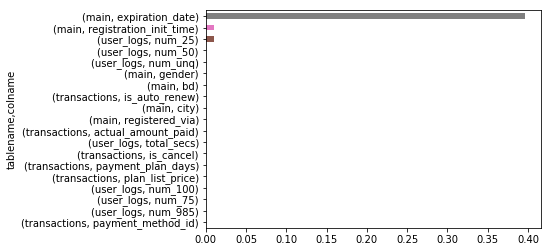

In [10]:
# Will be implemented as a function. Don't worry!
col_imp_df["roc_auc"].sort_values().plot(kind="barh")